## Load Dataset

In [ ]:
# Data Handling and Manipulation
import pandas as pd
import numpy as np

# Plotting and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb

# Statistical Methods
from scipy.stats import randint, uniform, stats

# Machine Learning and Model Training
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
import warnings

# Suppress warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

In [ ]:
# Define the path 
model_data = pd.read_csv(
    "C:\\Users\\shiri\\OneDrive\\Documents\\Python\\ml-projects\\data-606\\pharmaceutical-drug-price-prediction\\data\\processed\\model_drug_amp.csv"
)

In [ ]:
model_data.columns

Index(['product_group', 'ingredient', 'strength', 'dosage', 'route',
       'mdr_unit_type', 'weighted_average_of_amps', 'aca_ful', 'package_size',
       'ndc', 'year', 'month', 'strength_num', 'strength_ratio', 'gnrc_name',
       'tot_mftr', 'tot_spndng', 'tot_clms', 'tot_benes', 'tot_dsg_unts',
       'avg_spnd_per_dsg_unt_wghtd', 'avg_spnd_per_clm', 'avg_spnd_per_bene',
       'month_sin', 'month_cos', 'tot_mftr_avg_spnd_per_bene',
       'tot_mftr_tot_benes', 'avg_spnd_per_clm_avg_spnd_per_bene',
       'avg_dsg_units_per_clm', 'utilization_rate'],
      dtype='object')

## Prepare the data

In [ ]:
# Prepare the dataset
X = model_data[
    [
        'avg_dsg_units_per_clm',
        'avg_spnd_per_bene',
        'tot_mftr',
        'tot_spndng',
        'utilization_rate',
        'tot_clms',
        'avg_spnd_per_clm',
        'tot_mftr_avg_spnd_per_bene',
        "package_size"
    ]
]
y = model_data["weighted_average_of_amps"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## Traditional ML

### Linear Regression

In [ ]:
# Define and train Linear Regression
lr_regressor = LinearRegression()
lr_regressor.fit(X_train, y_train)
lr_train_predictions = lr_regressor.predict(X_train)
lr_test_predictions = lr_regressor.predict(X_test)

# Evaluate Linear Regression
lr_train_mse = mean_squared_error(y_train, lr_train_predictions)
lr_test_mse = mean_squared_error(y_test, lr_test_predictions)
lr_train_r2 = r2_score(y_train, lr_train_predictions)
lr_test_r2 = r2_score(y_test, lr_test_predictions)

# Print results
print("Linear Regression:")
print("Train MSE:", lr_train_mse)
print("Test MSE:", lr_test_mse)
print("Train R^2 score:", lr_train_r2)
print("Test R^2 score:", lr_test_r2)
print()

Linear Regression:
Train MSE: 111.32563590740227
Test MSE: 105.84940984694926
Train R^2 score: 0.30417608974609334
Test R^2 score: 0.31700817848820706



The Linear Regression model showed a Train MSE of 111.33 and a Test MSE of 105.85, with R² scores of about 0.30 and 0.32. This means it explains around 30% of the variation in drug pricing, which is modest. The similar training and testing scores suggest it isn’t overfitting, but the model may be too basic to fully capture complex relationships in the data.

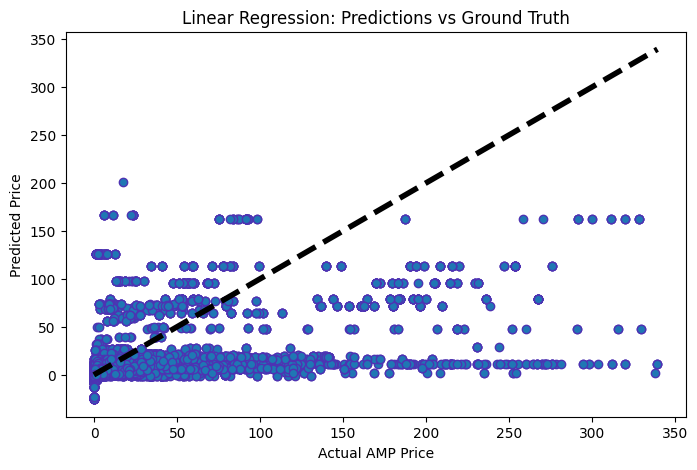

In [ ]:
# Scatter plot for predictions vs ground truth (actual values)
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the predicted vs actual values for the test data
ax.scatter(y_test, lr_test_predictions, edgecolors=(0.3, 0.2, 0.7))

# Plot the ideal line y = x (Perfect predictions line)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)

# Set labels and title
ax.set_xlabel("Actual AMP Price")
ax.set_ylabel("Predicted Price")
plt.title("Linear Regression: Predictions vs Ground Truth", fontdict=None, loc="center")

# Show the plot
plt.show()


#### Ridge Regression

In [ ]:
# Define the parameter distributions
param_dist = {
    'alpha': np.logspace(-2, 2, 5),
    'solver': ['auto', 'svd', 'cholesky', 'lsqr']
}

# Initialize the Ridge model
ridge = Ridge()

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(ridge, param_distributions=param_dist,
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error',
                                   verbose=1, random_state=42)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'solver': 'lsqr', 'alpha': np.float64(10.0)}


In [ ]:
# Get the best model from RandomizedSearchCV
best_ridge = random_search.best_estimator_

# Make predictions
ridge_train_predictions = best_ridge.predict(X_train)
ridge_test_predictions = best_ridge.predict(X_test)

# Evaluate Ridge Regression
ridge_train_mse = mean_squared_error(y_train, ridge_train_predictions)
ridge_test_mse = mean_squared_error(y_test, ridge_test_predictions)
ridge_train_r2 = r2_score(y_train, ridge_train_predictions)
ridge_test_r2 = r2_score(y_test, ridge_test_predictions)

# Print results
print("Ridge Regression:")
print("Best Hyperparameters:", random_search.best_params_)
print("Train MSE:", ridge_train_mse)
print("Test MSE:", ridge_test_mse)
print("Train R^2 score:", ridge_train_r2)
print("Test R^2 score:", ridge_test_r2)
print()

Ridge Regression:
Best Hyperparameters: {'solver': 'lsqr', 'alpha': np.float64(10.0)}
Train MSE: 111.32572070280881
Test MSE: 105.85116853663499
Train R^2 score: 0.30417555974533605
Test R^2 score: 0.316996830567858



The Ridge Regression model, even with regularization (alpha = 10), performed almost identically to Linear Regression. The MSE and R² scores didn’t change much, meaning that adding L2 regularization didn’t help much. This shows that issues like overfitting or multicollinearity weren’t major concerns for the simple linear approach.



### K-nearest neighbors Regressor

#### Distance-Based Models

In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=5)

# Fit and transform training data
X_train_pca = pca.fit_transform(X_train)

# Transform test data
X_test_pca = pca.transform(X_test)

# Initialize KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=5, algorithm="ball_tree")  # Use 'ball_tree' for efficient KNN

# Train the model on the training data
knn_model.fit(X_train_pca, y_train)

# Make predictions on the training and test sets
y_train_pred_knn = knn_model.predict(X_train_pca)
y_test_pred_knn = knn_model.predict(X_test_pca)

# Calculate MSE and R^2 for training and testing
train_mse_knn = mean_squared_error(y_train, y_train_pred_knn)
test_mse_knn = mean_squared_error(y_test, y_test_pred_knn)
train_r2_knn = r2_score(y_train, y_train_pred_knn)
test_r2_knn = r2_score(y_test, y_test_pred_knn)

# Print the results
print("K-Nearest Neighbors Regressor:")
print(f"Train MSE: {train_mse_knn}")
print(f"Test MSE: {test_mse_knn}")
print(f"Train R^2 score: {train_r2_knn}")
print(f"Test R^2 score: {test_r2_knn}")


K-Nearest Neighbors Regressor:
Train MSE: 28.36776484391556
Test MSE: 28.954244782259888
Train R^2 score: 0.8226916118828642
Test R^2 score: 0.8131731446313399


Compared to the linear and ridge regression models, the K-Nearest Neighbors (KNN) model did much better. It had a much lower MSE and higher R² scores—around 0.82 for both training and testing. This suggests KNN captured the patterns in the data more effectively, especially because it handles nonlinear relationships better than linear models.



In [ ]:
# Define the parameter distributions
param_dist = {
    'n_neighbors': randint(3, 11),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': randint(20, 50),
    'p': [1, 2]  # Manhattan or Euclidean
}

# Initialize KNN Regressor
knn = KNeighborsRegressor()

# Perform Randomized Search with 20 iterations on the subset
random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings to sample
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model using the subset data
random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters (Random Search):", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters (Random Search): {'algorithm': 'kd_tree', 'leaf_size': 29, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


In [ ]:
# Best hyperparameters from RandomizedSearchCV
best_knn_params = random_search.best_params_

# Initialize the best KNN Regressor using the found hyperparameters
best_knn_model = KNeighborsRegressor(
    n_neighbors=best_knn_params['n_neighbors'],
    weights=best_knn_params['weights'],
    algorithm=best_knn_params['algorithm'],
    leaf_size=best_knn_params['leaf_size'],
    p=best_knn_params['p']
)

# Fit the model on the PCA-transformed training data
best_knn_model.fit(X_train_pca, y_train)

# Make predictions using the trained model on both training and test data
y_train_pred_knn_best = best_knn_model.predict(X_train_pca)
y_test_pred_knn_best = best_knn_model.predict(X_test_pca)

# Calculate MSE and R^2 for training and testing
train_mse_knn_best = mean_squared_error(y_train, y_train_pred_knn_best)
test_mse_knn_best = mean_squared_error(y_test, y_test_pred_knn_best)
train_r2_knn_best = r2_score(y_train, y_train_pred_knn_best)
test_r2_knn_best = r2_score(y_test, y_test_pred_knn_best)

# Print the results after applying best hyperparameters
print("Best K-Nearest Neighbors Regressor:")
print(f"Train MSE: {train_mse_knn_best}")
print(f"Test MSE: {test_mse_knn_best}")
print(f"Train R^2 score: {train_r2_knn_best}")
print(f"Test R^2 score: {test_r2_knn_best}")

Best K-Nearest Neighbors Regressor:
Train MSE: 24.88502463169184
Test MSE: 25.34810708119512
Train R^2 score: 0.8444599484669348
Test R^2 score: 0.8364416971970448


After tuning, the KNN model performed even better. The R² scores improved to about 0.84 on training and 0.83 on testing, with lower MSEs. This means the model generalized well, and the fine-tuning helped it better capture the structure in the data without overfitting.



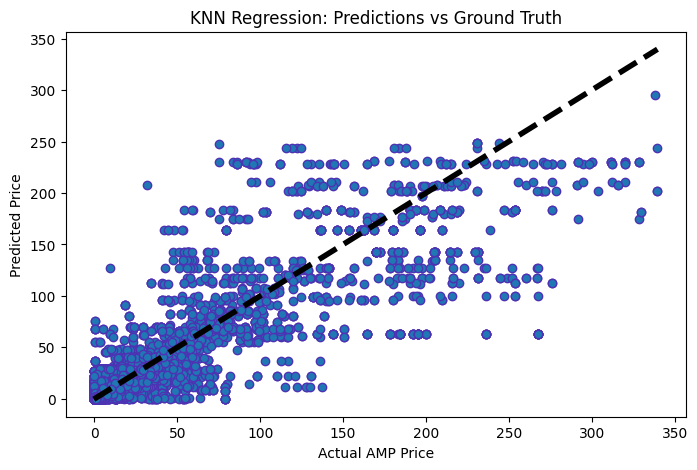

In [ ]:
# KNN: Actual vs Predicted
fig, ax = plt.subplots(figsize=(8, 5))

# Predicted vs Actual
ax.scatter(y_test, y_test_pred_knn, edgecolors=(0.3, 0.2, 0.7))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)

# Set labels and title
ax.set_xlabel("Actual AMP Price")
ax.set_ylabel("Predicted Price")
plt.title("KNN Regression: Predictions vs Ground Truth", fontdict=None, loc="center")

# Show the plot
plt.show()

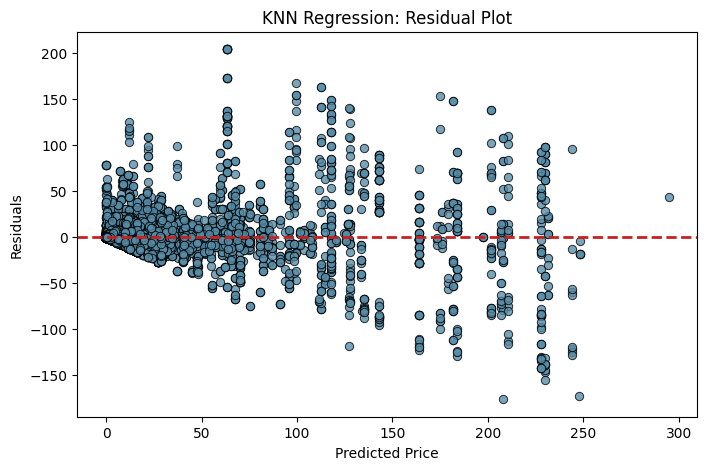

In [ ]:
# KNN: Residual Plot
residuals = y_test - y_test_pred_knn

fig, ax = plt.subplots(figsize=(8, 5))

# Scatter with custom fill and border colors
ax.scatter(
    y_test_pred_knn,
    residuals,
    facecolor="#588DA8",
    edgecolor="black",
    linewidth=0.7,
    alpha=0.8
)

# Custom horizontal line
ax.axhline(y=0, color="#C82121", linestyle='--', lw=2)

# Labels and title
ax.set_xlabel("Predicted Price")
ax.set_ylabel("Residuals")
plt.title("KNN Regression: Residual Plot", loc="center")
plt.show()


### Decision Tree Regressor

#### Tree-Based Models (Decision Boundaries)

In [ ]:
# Define and train Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)
dt_train_predictions = dt_regressor.predict(X_train)
dt_test_predictions = dt_regressor.predict(X_test)

# Evaluate Decision Tree Regressor
dt_train_mse = mean_squared_error(y_train, dt_train_predictions)
dt_test_mse = mean_squared_error(y_test, dt_test_predictions)
dt_train_r2 = r2_score(y_train, dt_train_predictions)
dt_test_r2 = r2_score(y_test, dt_test_predictions)

# Print results
print("Decision Tree Regressor:")
print("Train MSE:", dt_train_mse)
print("Test MSE:", dt_test_mse)
print("Train R^2 score:", dt_train_r2)
print("Test R^2 score:", dt_test_r2)
print()

Decision Tree Regressor:
Train MSE: 22.966228865710136
Test MSE: 22.800363202533653
Train R^2 score: 0.8564530887888511
Test R^2 score: 0.8528809785775321



The Decision Tree Regressor also performed strongly, with R² scores of around 0.86 for training and 0.85 for testing. The low MSEs and the close training and test scores show the model fit the data well and didn’t overfit. It outperformed linear models and showed that tree-based methods work well for this dataset.



In [ ]:
# Define the parameter distributions
param_dist = {
    "criterion": ["squared_error", "friedman_mse", "absolute_error"],
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 5),
    "max_features": ['sqrt', 'log2', None],
    "min_weight_fraction_leaf": uniform(0.0, 0.1),
    "max_leaf_nodes": [None, 10, 20, 30],
    "splitter": ['best', 'random']
}

# Initialize the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=dt_regressor,
    param_distributions=param_dist,
    n_iter=10,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters (Random Search):", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters (Random Search): {'criterion': 'absolute_error', 'max_depth': 20, 'max_features': 'log2', 'max_leaf_nodes': 30, 'min_samples_leaf': 4, 'min_samples_split': 7, 'min_weight_fraction_leaf': np.float64(7.787658410143284e-05), 'splitter': 'random'}


In [ ]:
# Run the RandomizedSearchCV and have the best hyperparameters
best_params = random_search.best_params_

# Initialize Decision Tree Regressor with the best hyperparameters
dt_regressor = DecisionTreeRegressor(random_state=42, **best_params)

# Fit the model on the full training data (X_train, y_train)
dt_regressor.fit(X_train, y_train)

# Make predictions on training and test sets
dt_train_predictions = dt_regressor.predict(X_train)
dt_test_predictions = dt_regressor.predict(X_test)

# Evaluate the model performance
dt_train_mse = mean_squared_error(y_train, dt_train_predictions)
dt_test_mse = mean_squared_error(y_test, dt_test_predictions)
dt_train_r2 = r2_score(y_train, dt_train_predictions)
dt_test_r2 = r2_score(y_test, dt_test_predictions)

# Print the results
print("Decision Tree Regressor:")
print("Train MSE:", dt_train_mse)
print("Test MSE:", dt_test_mse)
print("Train R^2 score:", dt_train_r2)
print("Test R^2 score:", dt_test_r2)

Decision Tree Regressor:
Train MSE: 65.98372631984614
Test MSE: 65.71651172300355
Train R^2 score: 0.5875787810528366
Test R^2 score: 0.5759651366030842


However, after tuning, the Decision Tree model didn’t perform as well. Its R² dropped to around 0.58–0.59 and MSE increased, suggesting the tuned version didn’t capture the data as effectively. It may have underfit or become too constrained due to the chosen parameters.



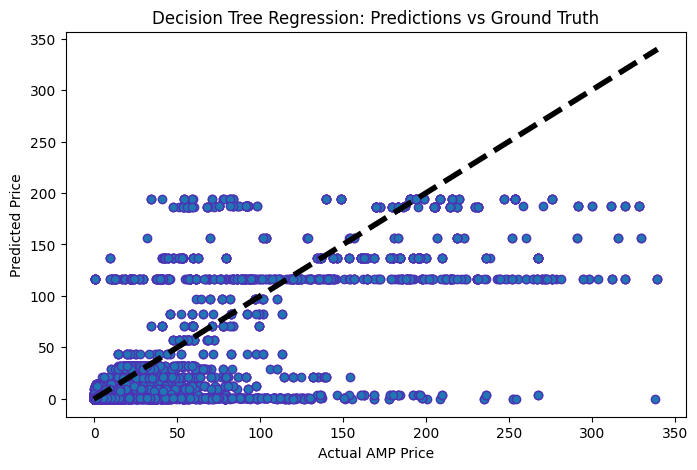

In [ ]:
# DT: Actual vs Predicted
fig, ax = plt.subplots(figsize=(8, 5))

# Predicted vs Actual
ax.scatter(y_test, dt_test_predictions, edgecolors=(0.3, 0.2, 0.7))  # Using dt_test_predictions
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)

# Set labels and title
ax.set_xlabel("Actual AMP Price")
ax.set_ylabel("Predicted Price")
plt.title("Decision Tree Regression: Predictions vs Ground Truth", loc="center")

# Show the plot
plt.show()

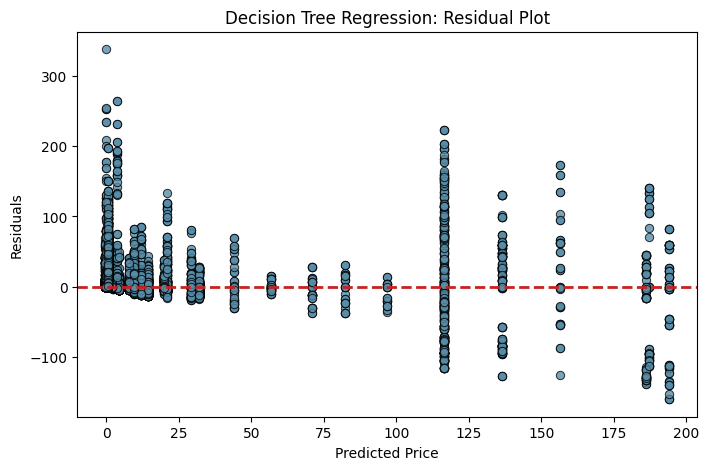

In [ ]:
# DT: Residual Plot
residuals_dt = y_test - dt_test_predictions

fig, ax = plt.subplots(figsize=(8, 5))

# Scatter with custom fill and border colors
ax.scatter(
    dt_test_predictions,
    residuals_dt,
    facecolor="#588DA8",
    edgecolor="black",
    linewidth=0.7,
    alpha=0.8
)

# Custom horizontal line at y=0
ax.axhline(y=0, color="#C82121", linestyle='--', lw=2)

# Labels and title
ax.set_xlabel("Predicted Price")
ax.set_ylabel("Residuals")
plt.title("Decision Tree Regression: Residual Plot", loc="center")
plt.show()


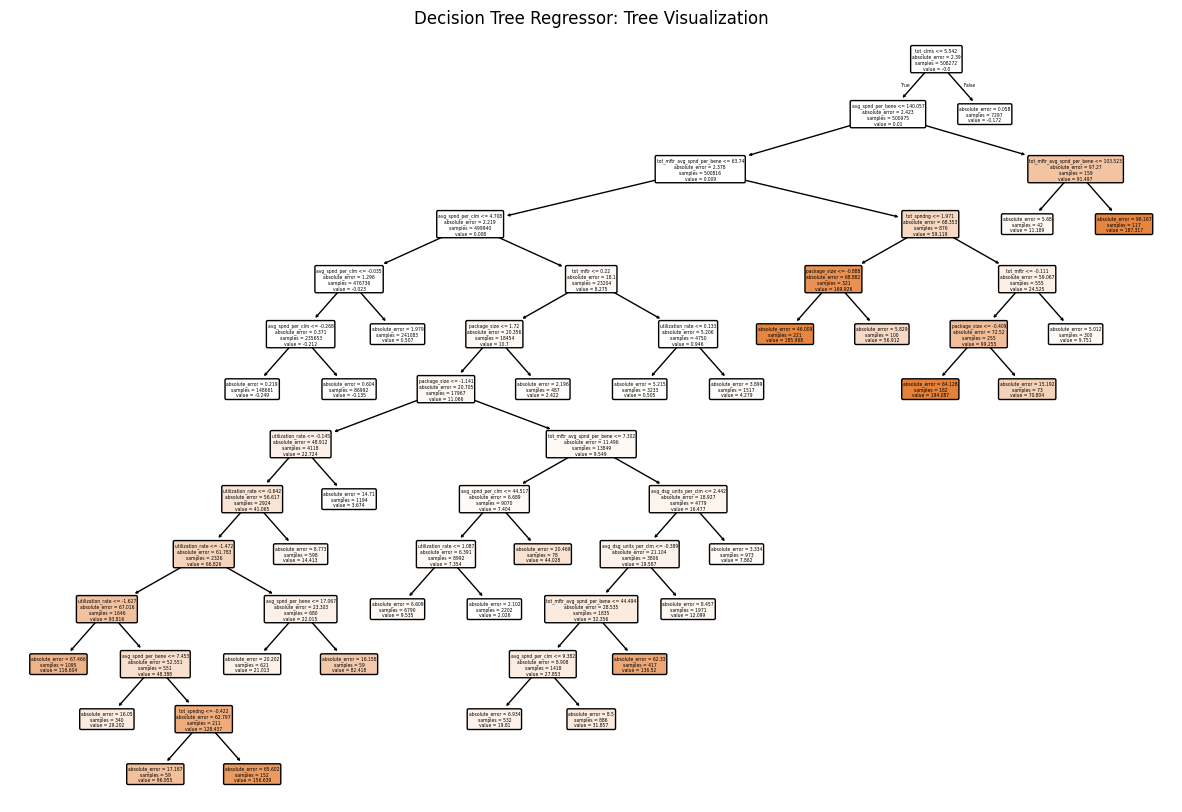

In [ ]:
# Decision Tree Plot (For small trees)
plt.figure(figsize=(15, 10))
plot_tree(dt_regressor, filled=True, feature_names=X_train.columns, class_names=["0", "1"], rounded=True)
plt.title("Decision Tree Regressor: Tree Visualization")
plt.show()

The decision tree model provides insights into how key features like average spending per claim, design units per claim, total spending, utilization rate, and package size impact the average manufacturer price of drugs (weighted average of amps). The model suggests that drugs with lower spending per claim tend to have lower prices, while those with higher spending, larger package sizes, and higher utilization rates are associated with higher prices. The most influential factor in determining drug prices is average spending per claim, followed by design units per claim and total spending, which help refine the price predictions. This model offers valuable insights into the relationship between drug pricing and various usage and spending patterns, which could inform decisions around pricing strategies and cost management.

## Ensemble Techniques

### Bagging Regressor

#### Bagging Techniques (Variance Reduction)

In [ ]:
# Define base estimator (Decision Tree)
base_dt = DecisionTreeRegressor(random_state=42)

# Create Bagging Regressor
bagging_regressor = BaggingRegressor(
    estimator=base_dt,   # Use 'estimator' instead of 'base_estimator'
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)

# Fit the Bagging Regressor
bagging_regressor.fit(X_train, y_train)

# Predictions
y_train_pred_bagging = bagging_regressor.predict(X_train)
y_test_pred_bagging = bagging_regressor.predict(X_test)

# Evaluation
bag_train_mse = mean_squared_error(y_train, y_train_pred_bagging)
bag_test_mse = mean_squared_error(y_test, y_test_pred_bagging)
bag_train_r2 = r2_score(y_train, y_train_pred_bagging)
bag_test_r2 = r2_score(y_test, y_test_pred_bagging)

# Print results
print("Bagging Regressor with Default Decision Tree:")
print("Train MSE:", bag_train_mse)
print("Test MSE:", bag_test_mse)
print("Train R^2 score:", bag_train_r2)
print("Test R^2 score:", bag_test_r2)

Bagging Regressor with Default Decision Tree:
Train MSE: 22.997282415019043
Test MSE: 22.8830274718721
Train R^2 score: 0.8562589933145134
Test R^2 score: 0.8523475885475731


The Bagging Regressor with a default Decision Tree showed performance similar to the regular Decision Tree. It had a good fit and consistent results for both training and testing, showing that the ensemble method added stability, but didn’t significantly outperform the base model.



In [ ]:
# Define the parameter distributions
param_dist = {
    'n_estimators': randint(10, 101),
    'max_samples': uniform(0.5, 0.5),
    'max_features': uniform(0.5, 0.5),
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

# Initialize Bagging Regressor
bagging = BaggingRegressor(random_state=42)

# Randomized SearchCV
random_search = RandomizedSearchCV(
    estimator=bagging,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the random search
random_search.fit(X_train, y_train)

# Print best hyperparameters
print("Best Hyperparameters (RandomizedSearch):", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters (RandomizedSearch): {'bootstrap': False, 'bootstrap_features': False, 'max_features': np.float64(0.9868777594207296), 'max_samples': np.float64(0.6163856702151521), 'n_estimators': 71}


In [ ]:
# Retrieve the best hyperparameters
best_params_bagging = random_search.best_params_

# Initialize new BaggingRegressor with the best params
best_bagging_model = BaggingRegressor(
    random_state=42,
    **best_params_bagging
)

# Fit the Bagging model
best_bagging_model.fit(X_train, y_train)

# Predictions
y_train_pred_bagging = best_bagging_model.predict(X_train)
y_test_pred_bagging = best_bagging_model.predict(X_test)

train_mse_bagging = mean_squared_error(y_train, y_train_pred_bagging)
test_mse_bagging = mean_squared_error(y_test, y_test_pred_bagging)
train_r2_bagging = r2_score(y_train, y_train_pred_bagging)
test_r2_bagging = r2_score(y_test, y_test_pred_bagging)

# Print results
print("Bagging Regressor:")
print("Train MSE:", train_mse_bagging)
print("Test MSE:", test_mse_bagging)
print("Train R^2 score:", train_r2_bagging)
print("Test R^2 score:", test_r2_bagging)



Final Bagging Regressor (Best Params):
Train MSE: 23.611663005682495
Test MSE: 23.29796051612902
Train R^2 score: 0.8524189011246504
Test R^2 score: 0.8496702389420132


With tuned parameters, the final Bagging Regressor still performed well, with close training and testing results. While the improvement over the default version wasn’t dramatic, it remained a solid and reliable model that generalized effectively to new data.

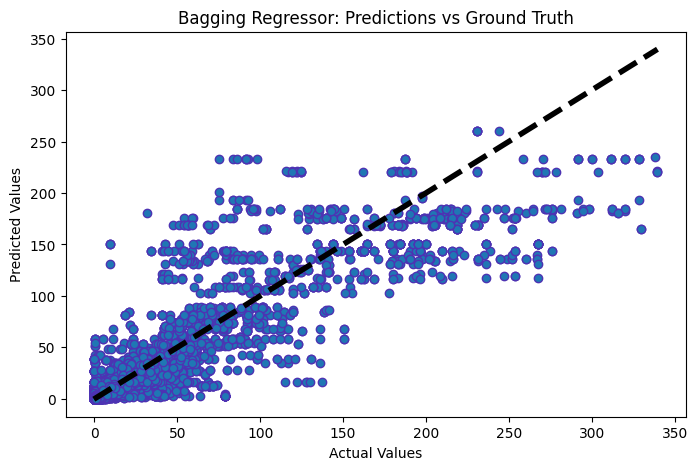

In [ ]:
# Bagging: Actual vs Predicted
y_test_pred_bagging = best_bagging_model.predict(X_test)

fig, ax = plt.subplots(figsize=(8, 5))

# Scatter plot: Predicted vs Actual
ax.scatter(y_test, y_test_pred_bagging, edgecolors=(0.3, 0.2, 0.7))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)

# Set labels and title
ax.set_xlabel("Actual Values")
ax.set_ylabel("Predicted Values")
plt.title("Bagging Regressor: Predictions vs Ground Truth", fontdict=None, loc="center")

plt.show()

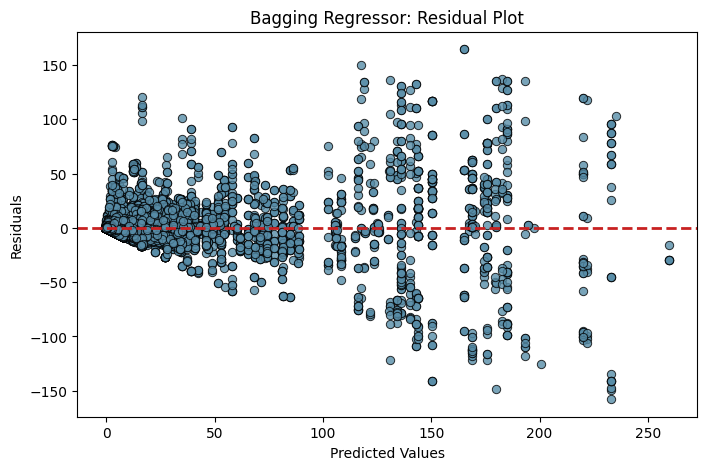

In [ ]:
# Bagging: Residual Plot
residuals_bagging = y_test - y_test_pred_bagging

fig, ax = plt.subplots(figsize=(8, 5))

# Scatter with custom fill and border colors
ax.scatter(
    y_test_pred_bagging,
    residuals_bagging,
    facecolor="#588DA8",
    edgecolor="black",
    linewidth=0.7,
    alpha=0.8
)

# Custom horizontal line at y=0
ax.axhline(y=0, color="#C82121", linestyle='--', lw=2)

# Labels and title
ax.set_xlabel("Predicted Values")
ax.set_ylabel("Residuals")
plt.title("Bagging Regressor: Residual Plot", loc="center")
plt.show()

### Random forest Regressor

#### (Bagging + Feature Sampling)

In [ ]:
# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate the MSE for both training and test sets
train_mse_rf = mean_squared_error(y_train, y_train_pred)
test_mse_rf = mean_squared_error(y_test, y_test_pred)

# Calculate the R² score for both training and test sets
train_r2_rf = r2_score(y_train, y_train_pred)
test_r2_rf = r2_score(y_test, y_test_pred)

# Output the results
print("Random Forest Regressor:")
print(f"Train MSE: {train_mse_rf}")
print(f"Test MSE: {test_mse_rf}")
print(f"Train R² score: {train_r2_rf}")
print(f"Test R² score: {test_r2_rf}")


Random Forest Regressor:
Train MSE: 22.97199677877645
Test MSE: 22.85260844403116
Train R² score: 0.8564170373278278
Test R² score: 0.8525438668949322


The Random Forest Regressor gave results similar to the Bagging Regressor in both MSE and R² scores. However, Random Forest had a slight edge, explaining a bit more of the variation in the data and providing slightly better predictive accuracy overall.

In [ ]:
# Define the parameter distributions
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 3),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Perform Randomized Search with 10 iterations
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model with Randomized Search
random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters (Random Search):", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters (Random Search): {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}


In [ ]:
# Run the best hyperparameters from RandomizedSearchCV
best_rf_params = random_search.best_params_

# Initialize the Random Forest Regressor with the best hyperparameters
rf_model = RandomForestRegressor(random_state=42, **best_rf_params)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate the MSE for both training and test sets
train_mse_rf = mean_squared_error(y_train, y_train_pred)
test_mse_rf = mean_squared_error(y_test, y_test_pred)

# Calculate the R² score for both training and test sets
train_r2_rf = r2_score(y_train, y_train_pred)
test_r2_rf = r2_score(y_test, y_test_pred)

# Output the results
print("Random Forest Regressor:")
print(f"Train MSE: {train_mse_rf}")
print(f"Test MSE: {test_mse_rf}")
print(f"Train R² score: {train_r2_rf}")
print(f"Test R² score: {test_r2_rf}")

Random Forest Regressor:
Train MSE: 22.971000811875186
Test MSE: 22.850300911781652
Train R² score: 0.8564232624670607
Test R² score: 0.8525587562141694


Even after tuning, the Random Forest Regressor didn't show much change from the default version. This suggests that the default settings were already well-suited for this dataset, and extra tuning didn’t bring notable improvements.

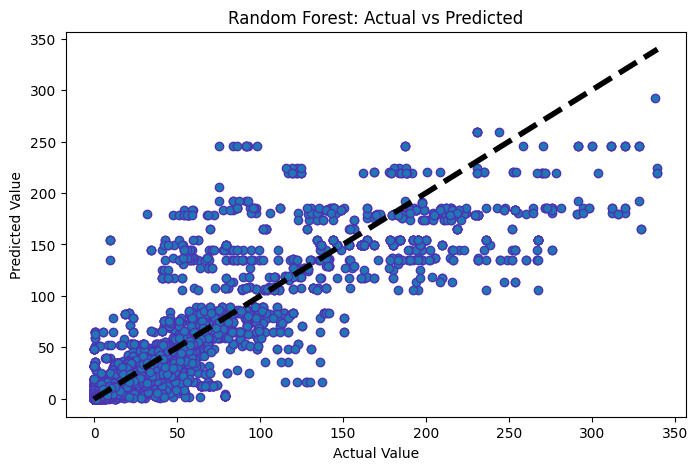

In [ ]:
# Actual vs Predicted Plot for Random Forest Regressor
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(y_test, y_test_pred, edgecolors=(0.3, 0.2, 0.7))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Actual Value")
ax.set_ylabel("Predicted Value")
plt.title("Random Forest: Actual vs Predicted")
plt.show()

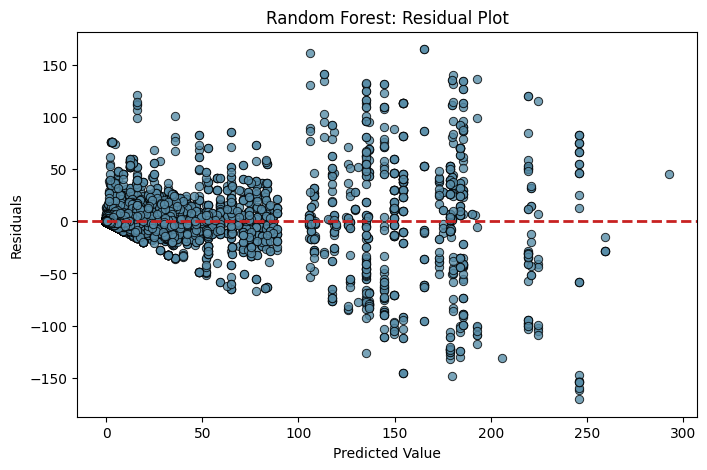

In [ ]:
# Residual Plot for Random Forest Regressor
residuals = y_test - y_test_pred
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(y_test_pred, residuals, facecolor="#588DA8", edgecolor="black", linewidth=0.7, alpha=0.8)
ax.axhline(y=0, color="#C82121", linestyle='--', lw=2)
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Residuals")
plt.title("Random Forest: Residual Plot")
plt.show()


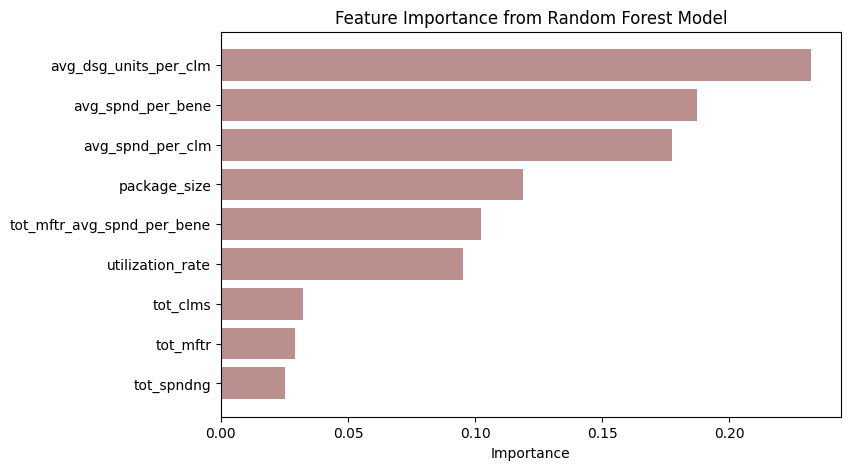

In [ ]:
# Feature Importance Plot for Random Forest Regressor
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(features[indices], importances[indices], color="rosybrown")
ax.set_xlabel("Importance")
ax.set_title("Feature Importance from Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

### Gradient Boosting Regressor

#### Boosting Techniques (Bias Reduction)

In [ ]:
# Initialize Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Fit the model
gb_model.fit(X_train, y_train)

# Predict on training and testing data
y_train_pred = gb_model.predict(X_train)
y_test_pred = gb_model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print("Gradient Boosting Regressor:")
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)
print("Train R^2 score:", train_r2)
print("Test R^2 score:", test_r2)

Gradient Boosting Regressor:
Train MSE: 33.904304509700665
Test MSE: 33.07441284025056
Train R^2 score: 0.7880863150155117
Test R^2 score: 0.7865878184502053


The Gradient Boosting Regressor performed reasonably well. The training and test scores were close, showing a balanced bias-variance trade-off. Although it didn’t outperform top models like KNN or Random Forest, it still offered consistent and dependable predictions.



In [ ]:
# Define the parameter distributions
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'subsample': uniform(0.7, 0.3),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the  model on the training data
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best Hyperparameters (RandomizedSearch):", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters (RandomizedSearch): {'learning_rate': np.float64(0.07530815376116708), 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 17, 'n_estimators': 131, 'subsample': np.float64(0.8619076397167239)}


In [ ]:
# Retrieve the best parameters
best_params_gb = random_search.best_params_

# Initialize the Gradient Boosting model with the best parameters
best_gb_model = GradientBoostingRegressor(
    n_estimators=best_params_gb['n_estimators'],
    learning_rate=best_params_gb['learning_rate'],
    max_depth=best_params_gb['max_depth'],
    min_samples_split=best_params_gb['min_samples_split'],
    min_samples_leaf=best_params_gb['min_samples_leaf'],
    subsample=best_params_gb['subsample'],
    max_features=best_params_gb['max_features'],
    random_state=42
)

# Fit the model on the training data
best_gb_model.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred_gb = best_gb_model.predict(X_train)
y_test_pred_gb = best_gb_model.predict(X_test)

# Evaluate the model
train_mse_gb = mean_squared_error(y_train, y_train_pred_gb)
test_mse_gb = mean_squared_error(y_test, y_test_pred_gb)
train_r2_gb = r2_score(y_train, y_train_pred_gb)
test_r2_gb = r2_score(y_test, y_test_pred_gb)

# Print the results
print("Gradient Boosting Regressor with Best Parameters:")
print("Train MSE:", train_mse_gb)
print("Test MSE:", test_mse_gb)
print("Train R^2 score:", train_r2_gb)
print("Test R^2 score:", test_r2_gb)

Gradient Boosting Regressor with Best Parameters:
Train MSE: 23.992010814317695
Test MSE: 23.87627761258055
Train R^2 score: 0.8500415951492218
Test R^2 score: 0.845938656048089


After tuning, the Gradient Boosting Regressor improved notably. Both the train and test MSEs dropped, and the R² scores stayed close, suggesting the model was well-tuned. The model learned better patterns without overfitting, leading to more reliable results.



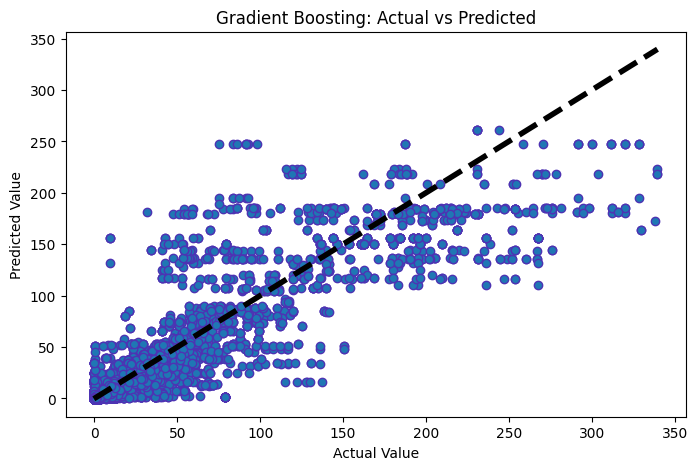

In [ ]:
# Actual vs Predicted Plot for Gradient Boosting
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(y_test, y_test_pred_gb, edgecolors=(0.3, 0.2, 0.7))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Actual Value")
ax.set_ylabel("Predicted Value")
plt.title("Gradient Boosting: Actual vs Predicted")
plt.show()


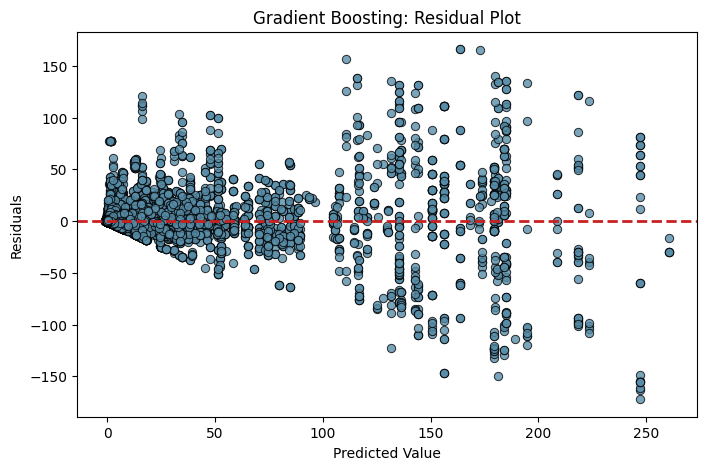

In [ ]:
# Residual Plot for Gradient Boosting
residuals = y_test - y_test_pred_gb
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(y_test_pred_gb, residuals, facecolor="#588DA8", edgecolor="black", linewidth=0.7, alpha=0.8)
ax.axhline(y=0, color="#C82121", linestyle='--', lw=2)
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Residuals")
plt.title("Gradient Boosting: Residual Plot")
plt.show()


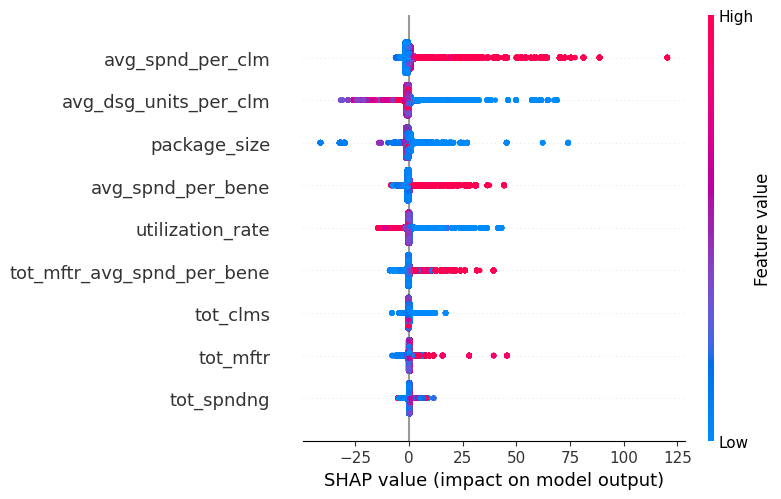

In [ ]:
# SHAP plot for Gradient Boosting
explainer = shap.Explainer(best_gb_model)
shap_values = explainer(X_train)

# SHAP summary plot
shap.summary_plot(shap_values, X_train)

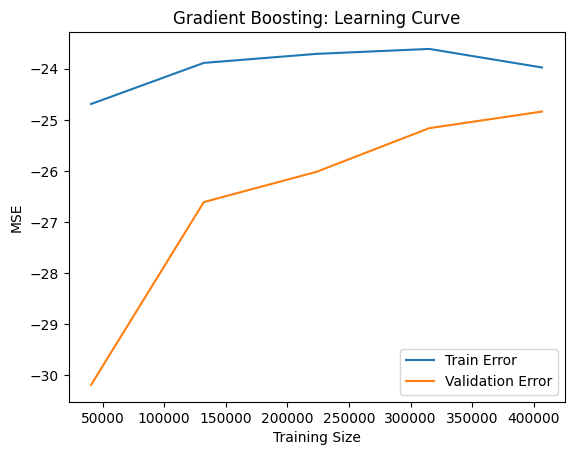

In [ ]:
# Learning curve for Gradient Boosting
train_sizes, train_scores, test_scores = learning_curve(
    best_gb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Plot learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label="Train Error")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Validation Error")
plt.xlabel("Training Size")
plt.ylabel("MSE")
plt.title("Gradient Boosting: Learning Curve")
plt.legend()
plt.show()

### XGBoost Regressor

#### Boosting Techniques (Bias Reduction)

In [ ]:
# Initialize the XGBoost Regressor model
xg_model = xgb.XGBRegressor(random_state=42)

# Fit the model
xg_model.fit(X_train, y_train)

# Predict on training and test data
y_train_pred = xg_model.predict(X_train)
y_test_pred = xg_model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print("XGBoost Regressor Results:")
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)
print("Train R^2 score:", train_r2)
print("Test R^2 score:", test_r2)

XGBoost Regressor Results:
Train MSE: 23.102355136494875
Test MSE: 22.896646614247093
Train R^2 score: 0.8556022522923543
Test R^2 score: 0.8522597112238206


The XGBoost Regressor delivered results very close to the best models, such as tuned Random Forest and Gradient Boosting. It had balanced R² scores and low MSE, making it a strong performer. XGBoost’s ability to handle complex data and train efficiently makes it a solid and dependable choice.



In [ ]:
# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

# Initialize XGBoost Regressor
xg_model = xgb.XGBRegressor(random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xg_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV model on the training data
random_search.fit(X_train, y_train)

# Print the best parameters found by RandomizedSearchCV
print("Best Hyperparameters (RandomizedSearch):", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters (RandomizedSearch): {'colsample_bytree': np.float64(0.7039794883479599), 'learning_rate': np.float64(0.19844035113697056), 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 58, 'subsample': np.float64(0.7047898756660642)}


In [ ]:
# Get the best XGBoost model with optimal hyperparameters
best_xg_model = random_search.best_estimator_

# Predict on training and test data
y_train_pred = best_xg_model.predict(X_train)
y_test_pred = best_xg_model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation results
print("XGBoost Regressor:")
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)
print("Train R^2 score:", train_r2)
print("Test R^2 score:", test_r2)

XGBoost Regressor:
Train MSE: 23.63043127665606
Test MSE: 23.634838430378633
Train R^2 score: 0.852301592909062
Test R^2 score: 0.8474965389599999


The XGBoost Regressor performs well with a training MSE of 23.63 and a test MSE of 23.63, showing that the model generalizes well to new data. The R² scores of 0.85 for both training and test sets suggest a good fit. When compared to other models like Random Forest and Gradient Boosting, XGBoost delivers similar results but with a slight edge in balancing the bias-variance trade-off, so it’s neither overfitting nor underfitting the data too much.

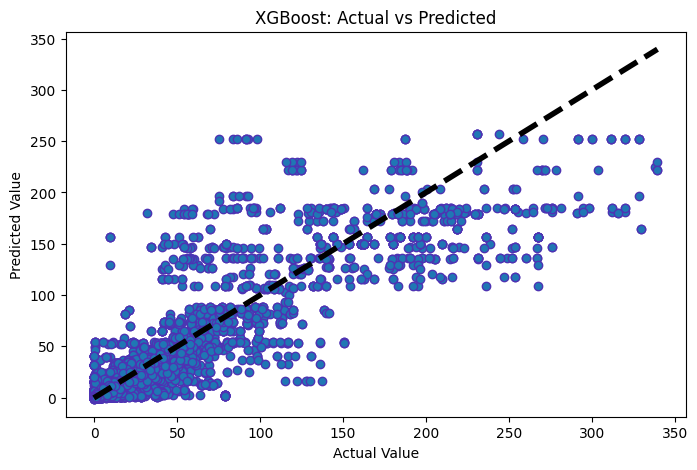

In [ ]:
# Actual vs Predicted Plot for Gradient Boosting
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(y_test, y_test_pred, edgecolors=(0.3, 0.2, 0.7))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Actual Value")
ax.set_ylabel("Predicted Value")
plt.title("XGBoost: Actual vs Predicted")
plt.show()


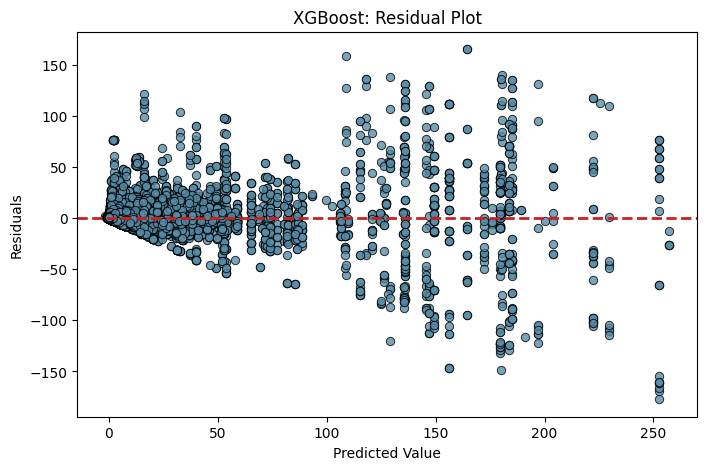

In [ ]:
# Residual Plot for Gradient Boosting
residuals = y_test - y_test_pred
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(y_test_pred, residuals, facecolor="#588DA8", edgecolor="black", linewidth=0.7, alpha=0.8)
ax.axhline(y=0, color="#C82121", linestyle='--', lw=2)
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Residuals")
plt.title("XGBoost: Residual Plot")
plt.show()

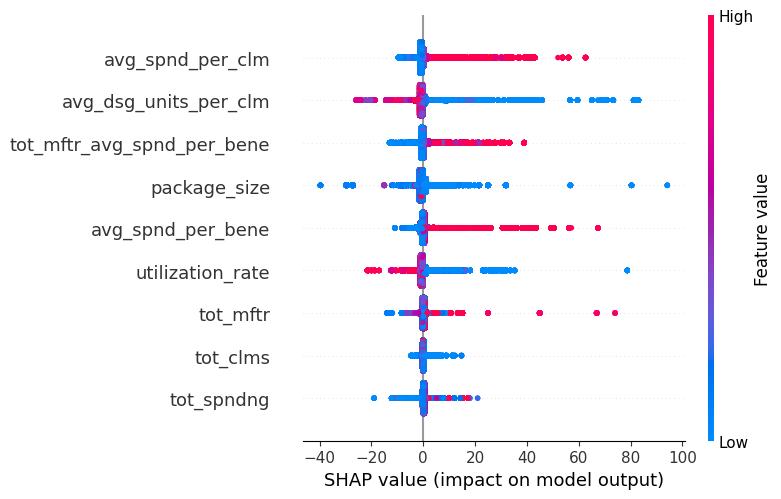

In [ ]:
# SHAP plot for XGBoost
explainer = shap.Explainer(best_xg_model)
shap_values = explainer(X_train)

# SHAP summary plot
shap.summary_plot(shap_values, X_train)

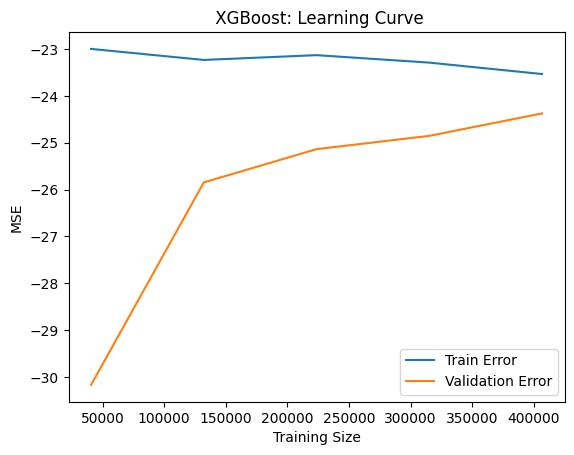

In [ ]:
# Learning curve for XGBoost
train_sizes, train_scores, test_scores = learning_curve(
    best_xg_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Plot learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label="Train Error")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Validation Error")
plt.xlabel("Training Size")
plt.ylabel("MSE")
plt.title(" XGBoost: Learning Curve")
plt.legend()
plt.show()

## Ensemble - Stacking (Model of Models)

### Stacking

In [ ]:
# Base models for stacking
base_models = [
    ('bagging', best_bagging_model),
    ('gbr', best_gb_model)
]

# Meta-model
meta_model = LinearRegression()

# Create the Stacking Regressor with the base models and final model
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Fit the stacking model
stacking_model.fit(X_train, y_train)

# Predict
y_train_pred = stacking_model.predict(X_train)
y_test_pred = stacking_model.predict(X_test)

# Evaluate the performance
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)


# Print the results
print("Stacking Regressor:")
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)
print("Train R^2 score:", train_r2)
print("Test R^2 score:", test_r2)

Stacking Regressor:
Train MSE: 23.509860983951278
Test MSE: 23.236810198716295
Train R^2 score: 0.8530551991368324
Test R^2 score: 0.8500648105011379


The Stacking Regressor performed very well, achieving low MSE values and high R² scores—around 0.85 for both training and testing. This shows that the model effectively learned the patterns in the data while maintaining good generalization. The close match between train and test scores suggests it has a strong balance between bias and variance, making it one of the most reliable models in this comparison.


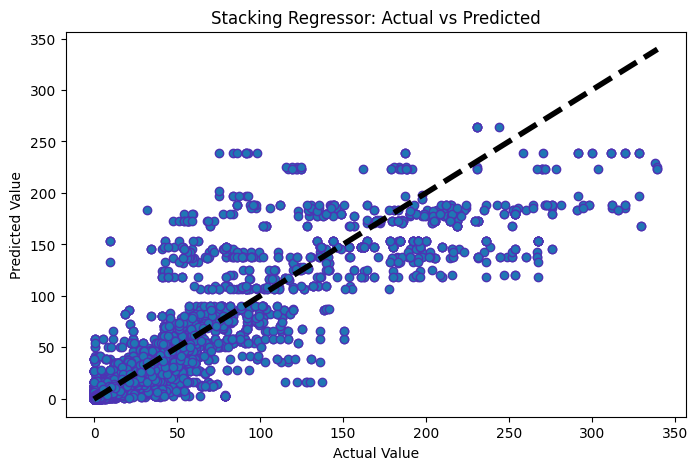

In [ ]:
# Actual vs Predicted Plot for Stacking Regressor
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(y_test, y_test_pred, edgecolors=(0.3, 0.2, 0.7))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Actual Value")
ax.set_ylabel("Predicted Value")
plt.title("Stacking Regressor: Actual vs Predicted")
plt.show()


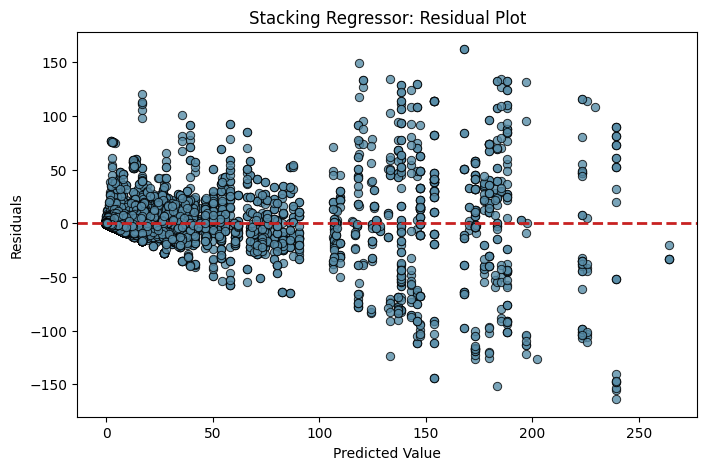

In [ ]:
# Residual Plot for Stacking Regressor
residuals = y_test - y_test_pred
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(y_test_pred, residuals, facecolor="#588DA8", edgecolor="black", linewidth=0.7, alpha=0.8)
ax.axhline(y=0, color="#C82121", linestyle='--', lw=2)
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Residuals")
plt.title("Stacking Regressor: Residual Plot")
plt.show()

In [ ]:
# Evaluate individual base learners and meta-model
for name, model in base_models:
    y_pred = model.predict(X_test)
    print(f"{name} - MSE: {mean_squared_error(y_test, y_pred)}, R²: {r2_score(y_test, y_pred)}")

# Meta-model evaluation
y_pred_meta = stacking_model.predict(X_test)
print(f"Meta-model - MSE: {mean_squared_error(y_test, y_pred_meta)}, R²: {r2_score(y_test, y_pred_meta)}")

bagging - MSE: 23.29796051612902, R²: 0.8496702389420132
gbr - MSE: 23.87627761258055, R²: 0.845938656048089
Meta-model - MSE: 23.236810198716295, R²: 0.8500648105011379


Among the three models, the Stacking Regressor (meta-model) achieved the best overall results with the lowest test MSE and the highest R² score, showing it captured the data patterns most effectively while generalizing well. The Bagging Regressor came very close, with slightly higher error but nearly the same R², making it another strong and reliable choice. The Gradient Boosting Regressor, while still performing well, had a slightly higher MSE and a marginally lower R² score compared to the other two, indicating that the ensemble methods like Bagging and Stacking offered better predictive accuracy for this dataset.


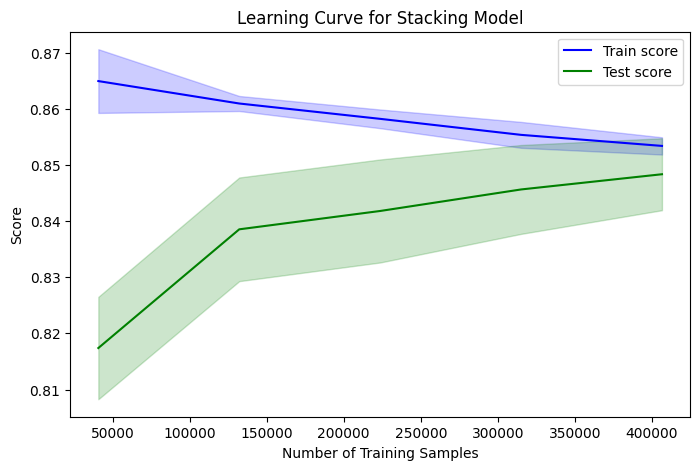

In [ ]:
# Plotting Learning Curve for Stacking Model
train_sizes, train_scores, test_scores = learning_curve(stacking_model, X_train, y_train, cv=5, n_jobs=-1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores.mean(axis=1), label="Train score", color="blue")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Test score", color="green")
plt.fill_between(train_sizes, train_scores.mean(axis=1) - train_scores.std(axis=1), train_scores.mean(axis=1) + train_scores.std(axis=1), color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_scores.mean(axis=1) - test_scores.std(axis=1), test_scores.mean(axis=1) + test_scores.std(axis=1), color='green', alpha=0.2)

plt.xlabel("Number of Training Samples")
plt.ylabel("Score")
plt.title("Learning Curve for Stacking Model")
plt.legend()
plt.show()

## Advanced Techniques

### Neural Network

In [ ]:
# Define the neural network model
class DeepRegressor(nn.Module):
    def __init__(self, input_dim):
        super(DeepRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(),

            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),

            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),

            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.LeakyReLU(),

            nn.Linear(32, 1)
        )
        self._initialize_weights()

    def forward(self, x):
        return self.layers(x)

    def _initialize_weights(self):
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

In [ ]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=10, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, r2, model):
        score = r2
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100):
    train_losses, val_losses, train_r2s, val_r2s = [], [], [], []
    early_stopping = EarlyStopping(patience=10)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_train_preds, all_train_labels = [], []

        # Training phase
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            all_train_preds.extend(outputs.detach().cpu().numpy())  # Detach before using numpy()
            all_train_labels.extend(labels.cpu().numpy())

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calculate train R2
        train_r2 = r2_score(all_train_labels, all_train_preds)
        train_r2s.append(train_r2)

        model.eval()
        val_loss = 0.0
        all_val_preds, all_val_labels = [], []

        # Validation phase
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                all_val_preds.extend(outputs.detach().cpu().numpy())  # Detach before using numpy()
                all_val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate validation R2
        val_r2 = r2_score(all_val_labels, all_val_preds)
        val_r2s.append(val_r2)

        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")

        # Early stopping based on validation R2
        early_stopping(val_r2, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_r2s, val_r2s

In [ ]:
# Data
train_data = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
val_data = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# Model
input_dim = X_train.shape[1]
model = DeepRegressor(input_dim)

# Loss, optimizer, scheduler
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=4, min_lr=1e-6)

In [ ]:
# Train
train_losses, val_losses, train_r2s, val_r2s = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler)

Epoch 1/100 | Train Loss: 82.7708 | Val Loss: 48.3206 | Train R²: 0.4826 | Val R²: 0.6882
Epoch 2/100 | Train Loss: 50.6777 | Val Loss: 44.3392 | Train R²: 0.6832 | Val R²: 0.7139
Epoch 3/100 | Train Loss: 45.5558 | Val Loss: 40.2967 | Train R²: 0.7153 | Val R²: 0.7400
Epoch 4/100 | Train Loss: 44.0698 | Val Loss: 38.9946 | Train R²: 0.7246 | Val R²: 0.7484
Epoch 5/100 | Train Loss: 43.5321 | Val Loss: 43.4058 | Train R²: 0.7279 | Val R²: 0.7199
Epoch 6/100 | Train Loss: 42.4175 | Val Loss: 39.3157 | Train R²: 0.7349 | Val R²: 0.7463
Epoch 7/100 | Train Loss: 42.0267 | Val Loss: 39.4842 | Train R²: 0.7373 | Val R²: 0.7452
Epoch 8/100 | Train Loss: 41.7019 | Val Loss: 43.3966 | Train R²: 0.7393 | Val R²: 0.7200
Epoch 9/100 | Train Loss: 40.6150 | Val Loss: 38.1304 | Train R²: 0.7461 | Val R²: 0.7539
Epoch 10/100 | Train Loss: 40.4679 | Val Loss: 36.7628 | Train R²: 0.7471 | Val R²: 0.7628
Epoch 11/100 | Train Loss: 39.6693 | Val Loss: 36.5679 | Train R²: 0.7520 | Val R²: 0.7640
Epoch 12

The model improves steadily over the 100 training rounds. At first, the training and validation errors are high, but as the training goes on, both errors decrease, and the model's accuracy improves. By the middle of the training, the results become more stable, and the model performs well on both training and unseen validation data. This shows that the model is learning the patterns in the data effectively without overfitting.

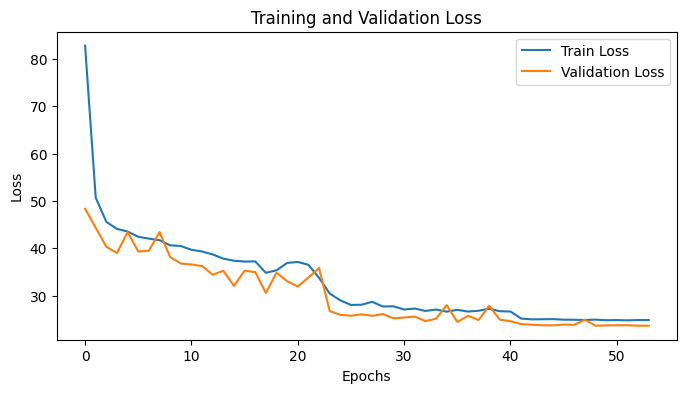

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

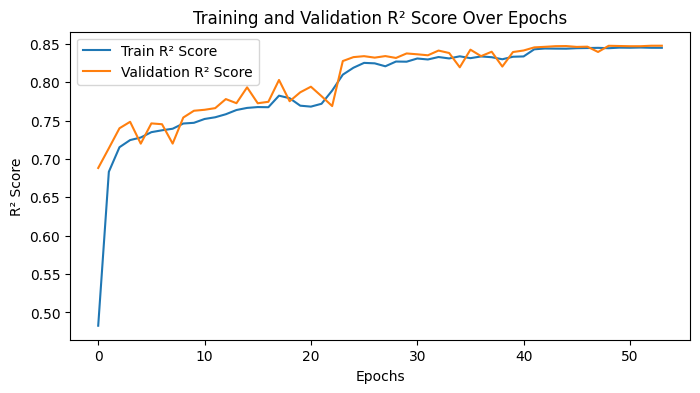

In [ ]:
# Plot the R2 score (training and validation)
plt.figure(figsize=(8, 4))
plt.plot(train_r2s, label='Train R² Score')
plt.plot(val_r2s, label='Validation R² Score')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()
plt.title('Training and Validation R² Score Over Epochs')
plt.show()

## Conclusion

While simpler models like linear regression struggled to provide accurate predictions, the ensemble models—such as Bagging, Random Forest, and XGBoost—showed much stronger performance. These models, which combine multiple weaker models to make better predictions, demonstrated the power of leveraging more complex approaches. Among them, the Stacking Regressor stood out by slightly outperforming the others, making it the most reliable choice for this particular task. This suggests that combining the strengths of different models can lead to more accurate and robust predictions, and in this case, the Stacking Regressor proved to be the best option. It highlights how ensemble methods can be especially effective when a single model isn't sufficient to capture the complexity of the data.